# Setup

In [ ]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [ ]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis númericas foram normalizadas antes da entrada na rede
- Variável categórica sofreu one hot encoding

A transformação dos dados é feita no mesmo momento que o modelo é treinado, isso é feito através da criacão de um modelo que não diferenciado numéricamente e vai somente processar os dados de entrada. 

In [ ]:
#@title Definir subset para o modelo
cols = ['preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'mercado', 'preco_opcao']
features = data[cols].copy()
labels = features.pop('preco_opcao')

In [ ]:
#@title Definir variáveis de entrada
inputs = {}

for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [ ]:
#@title Definir variáveis númericas e normalizar
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate(name='concatenate_numeric')(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

In [ ]:
#@title Definir categóricas e aplicar one hot encoding
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

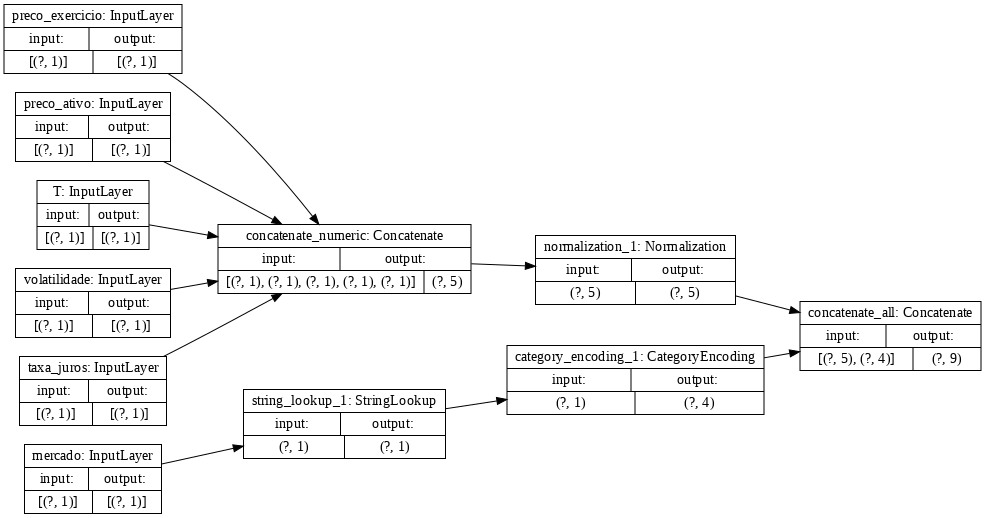

In [ ]:
#@title Concatenar dados de entrada e criar modelo para processamento das variavéis
preprocessed_inputs_cat = tf.keras.layers.Concatenate(name='concatenate_all')(preprocessed_inputs)
model_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
tf.keras.utils.plot_model(model=model_preprocessing, rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
#@title Amostra de dados processados
sample_features_dict = {name: np.array(value) for name, value in features.items()}
sample_features_dict = {name: values[:1] for name, values in sample_features_dict.items()}
model_preprocessing(sample_features_dict)

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.16609144, -1.262118  , -0.5997047 ,  1.6308359 ,  0.5813974 ,
         0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)>

In [ ]:
#@title tf.Data
def df_to_dataset(dataframe, base, shuffle=True, batch_size=22):

    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe['base'] == base]
    labels = dataframe.pop('preco_opcao')
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros']
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols]), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size)

# Divisão da base de treino e teste
train_ds = df_to_dataset(data, base='treino')
test_ds = df_to_dataset(data, shuffle=False, base='teste')

# Modelo

O modelo de rede neural profunda a seguir, foi baseado nos estudos desenvolvidos por Hirsa, Karatas, & Oskoui. No trabalho são testadas diversas arquiteturas (camadas e elementos em cada camada), bem como função de atição de cada camada e também função de otimização.

A conclusão do estudo mostra que os melhores resultados foram obtidos utilizando uma rede de 4 camadas com 120 neurônios cada uma.

In [ ]:
#@title Criar, compilar o modelo
# Define de model
def get_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)]
    )

    return model

model = get_model(model_preprocessing, inputs)

In [ ]:
#@title Callbacks
# Tensorflow checkpoint
path = '/content/drive/MyDrive/Mestrado/models/dnn/'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'checkpoint',
    frequecy='epoch',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2, min_delta=0.001, patience=5, verbose=1)

csv = tf.keras.callbacks.CSVLogger(path+"results.csv")

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1)

In [ ]:
#@title Treinar o modelo
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=[checkpoint, lr, csv, es]
    )

Epoch 1/200
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
7400/7416 [============================>.] - ETA: 0s - loss: 0.1481 - MAE: 0.1988WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'mercado': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'preco_exercicio': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'preco_ativo': <tf.Tensor 'E

In [ ]:
#@title Métricas
metrics = pd.read_csv(path + 'results.csv')
metrics.head()

,epoch,MAE,loss,lr,val_MAE,val_loss
0,0,0.198646,0.147931,0.001,0.187843,0.090450
1,1,0.161631,0.073710,0.001,0.133134,0.064761
2,2,0.149648,0.065891,0.001,0.157252,0.082794
3,3,0.144901,0.063680,0.001,0.132088,0.059503
4,4,0.141864,0.061789,0.001,0.129226,0.058398


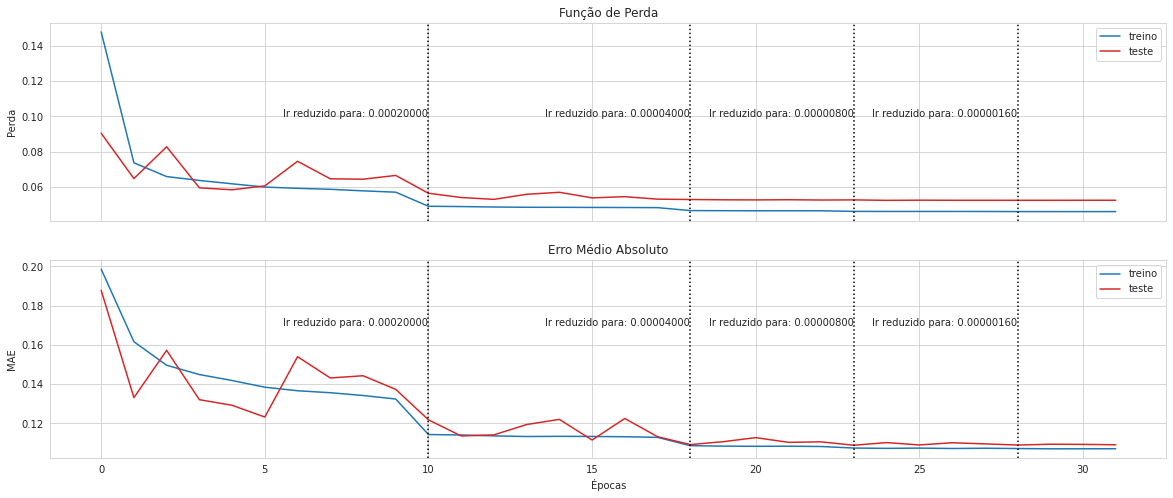

In [ ]:
#@title Plot das Métricas do Modelo

# Valor de mudança de learning rate
metrics['lr_change'] = metrics['lr'] == metrics['lr'].shift(1)

# Valores de learning para plot de gráfico
lr_change = metrics.loc[metrics['lr_change'] == False, ['epoch', 'lr']]

# Retirar a primeira linha
lr_change = lr_change[1:]

# Converter para dict
lr_change = lr_change.to_dict('records')

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(metrics['epoch'], metrics['loss'], 'tab:blue', label='treino')
axs[0].plot(metrics['epoch'], metrics['val_loss'], 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
axs[0].legend()

axs[1].plot(metrics['epoch'], metrics['MAE'], 'tab:blue', label='treino')
axs[1].plot(metrics['epoch'], metrics['val_MAE'], 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
axs[1].legend()

for lr in lr_change:
    axs[0].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    axs[1].axvline(x=lr['epoch'], linestyle='dotted', color='black')
    axs[0].text(
        x=lr['epoch'],
        y=0.1,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='right'
        )
    axs[1].text(
        x=lr['epoch'],
        y=0.17,
        s=f"lr reduzido para: {lr['lr']:.8f}",
        horizontalalignment='right'
        )

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
#@title Carregar o melhor modelo
model = get_model(model_preprocessing, inputs)
model.load_weights(path+'checkpoint')

# Predição na base de teste
prediction = model.predict(test_ds)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [ ]:
#@title Salvar predição
np.savez_compressed('/content/drive/My Drive/Mestrado/data/predicao_dnn.npz', dnn=prediction)

# Reference

Hirsa, A., Karatas, T., & Oskoui, A. (2019). Supervised deep neural networks (DNNS) for pricing/calibration of vanilla/exotic options under various different processes.